In [61]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.



In [62]:
tennis <- read_csv('player_stats.csv')
colnames(tennis) <- make.names(colnames(tennis))

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [89]:
tennis_data <- tennis |>
filter(Active == "Yes") |>
select(Age:Plays, Current.Rank:Prize.Money, Seasons, Current.Elo.Rank:Peak.Elo.Rating) |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Best.Rank, into = c("Best.Rank", "Best.Rank.Date"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
separate(col = Best.Elo.Rank, into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"), sep = " ") |>
separate(col = Peak.Elo.Rating, into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"), sep = " ") |>
mutate(Current.Rank = as.numeric(Current.Rank), Current.Elo.Rank = as.numeric(Current.Elo.Rank),
       Best.Elo.Rank = as.numeric(Best.Elo.Rank), Peak.Elo.Rating = as.numeric(Peak.Elo.Rating), Best.Rank = as.numeric(Best.Rank),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prev.Rank = as.numeric(gsub("[^0-9.-]", "", Prev.Rank)),
       Money.Per.Season = Prize.Money/Seasons) |>
    select(Name, Age, Seasons, Current.Rank, Prev.Rank, Best.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Elo.Rank, Peak.Elo.Rating,
           Prize.Money, Money.Per.Season)
tennis_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Name,Age,Seasons,Current.Rank,Prev.Rank,Best.Rank,Current.Elo.Rank,Current.Elo.Rating,Best.Elo.Rank,Peak.Elo.Rating,Prize.Money,Money.Per.Season
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,14,178,280,44,144,1764,60,1886,3261567,232969.1
Duck Hee Lee,21,2,236,199,130,NA,NA,NA,NA,374093,187046.5
Bernard Tomic,27,11,183,273,17,100,1826,21,2037,6091971,553815.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Dimitar Kuzmanov,26,8,324,120,249,180,1679,179,1679,132871,16608.88
Artem Dubrivnyy,20,1,397,89,394,NA,NA,NA,NA,40724,40724.00
Dominic Thiem,26,10,5,5890,4,6,2188,5,2211,NA,NA


In [90]:
set.seed(16)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

Below is a table organizing the players by number of active seasons, and giving the mean values for potential predicotr variables. Additionally, we included a table containing the amount of missing values for each predictor variable over our training set.

In [91]:
players_by_seasons <- tennis_training |>
    group_by(Seasons) |>
    summarize(count = n(), Mean.Best.Rank = mean(Best.Rank,na.rm = TRUE), Mean.Peak.Rating = mean(Peak.Elo.Rating,na.rm = TRUE),
              Mean.Current.Rank = mean(Current.Rank, na.rm = TRUE), Mean.Current.Rating = mean(Current.Elo.Rating, na.rm = TRUE))
missing_tennis_data <- tennis_training |>
    summarize(Active.Players = n(),
              Missing.Best.Rank = sum(is.na(Best.Rank)),
              Missing.Current.Rank = sum(is.na(Current.Rank)),
              Missing.Peak.Elo = sum(is.na(Peak.Elo.Rating)),
              Missing.Current.Elo = sum(is.na(Current.Elo.Rating)))
players_by_seasons
missing_tennis_data

Seasons,count,Mean.Best.Rank,Mean.Peak.Rating,Mean.Current.Rank,Mean.Current.Rating
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,312.7857,NaN,335.5714,NaN
2,21,203.0952,1792.000,245.7619,1784.000
3,25,142.6400,1839.273,187.7200,1812.364
⋮,⋮,⋮,⋮,⋮,⋮
20,2,25.5,2016,157.5,1846
21,1,5.0,2106,200.0,NaN
22,1,12.0,2074,57.0,1944


Active.Players,Missing.Best.Rank,Missing.Current.Rank,Missing.Peak.Elo,Missing.Current.Elo
<int>,<int>,<int>,<int>,<int>
210,0,0,54,74


Below are some plots visualizing the relationships between potential predictor variables and Prize Money, or Prize Money per Season.
Due to being an extreme outlier in terms of Prize Money, for visualization purposes we have removed Rafael Nadal from the data set. We still plan to use him in our model.

In [92]:
tennis_data_for_viz <- tennis_training |>
    filter(Name != "Rafael Nadal")

$title
[1] "Seasons vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Seasons vs Money per Seasons"

attr(,"class")
[1] "labels"

$title
[1] "Age vs Money Per Season"

attr(,"class")
[1] "labels"

$title
[1] "Peak Elo Rating vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Best Rank vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Current Elo vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Current Elo Rating"

attr(,"class")
[1] "labels"

Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


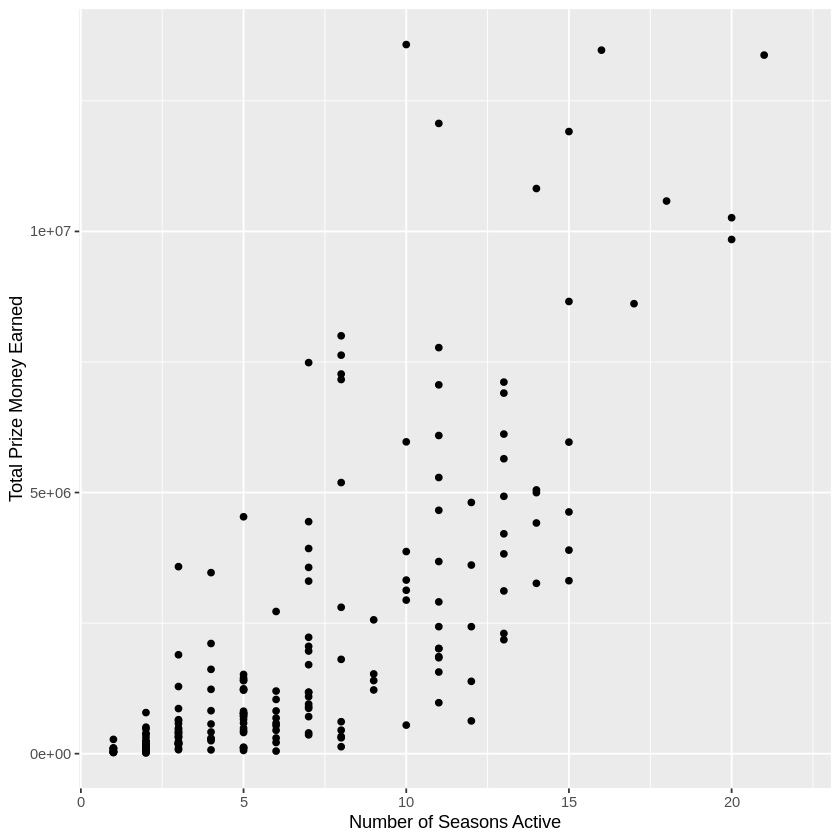

Warning message:
“Removed 20 rows containing missing values (geom_point).”


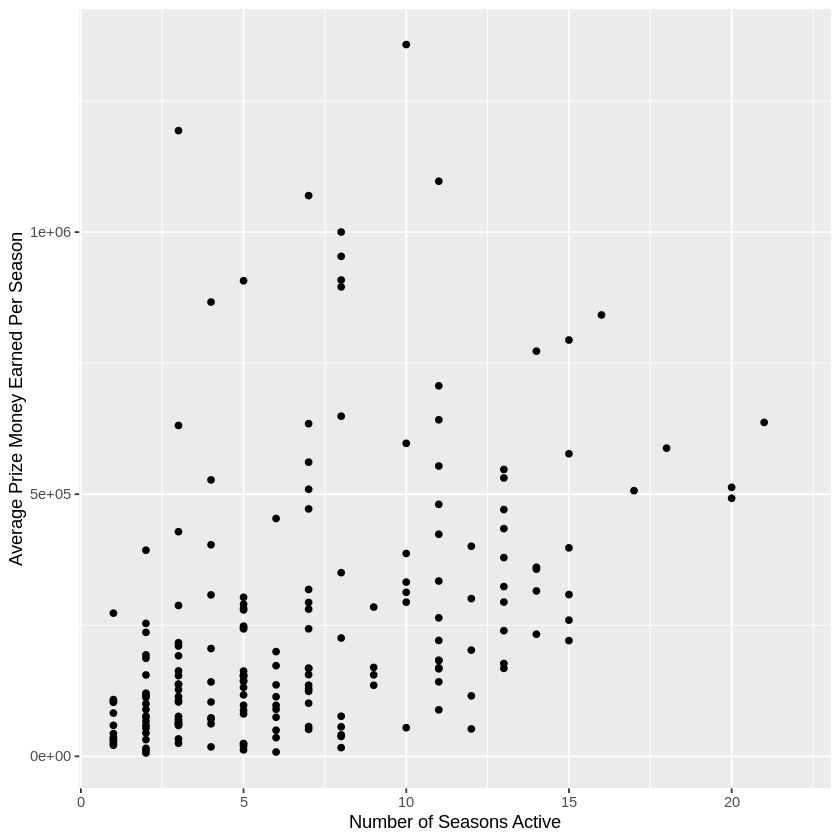

Warning message:
“Removed 71 rows containing missing values (geom_point).”


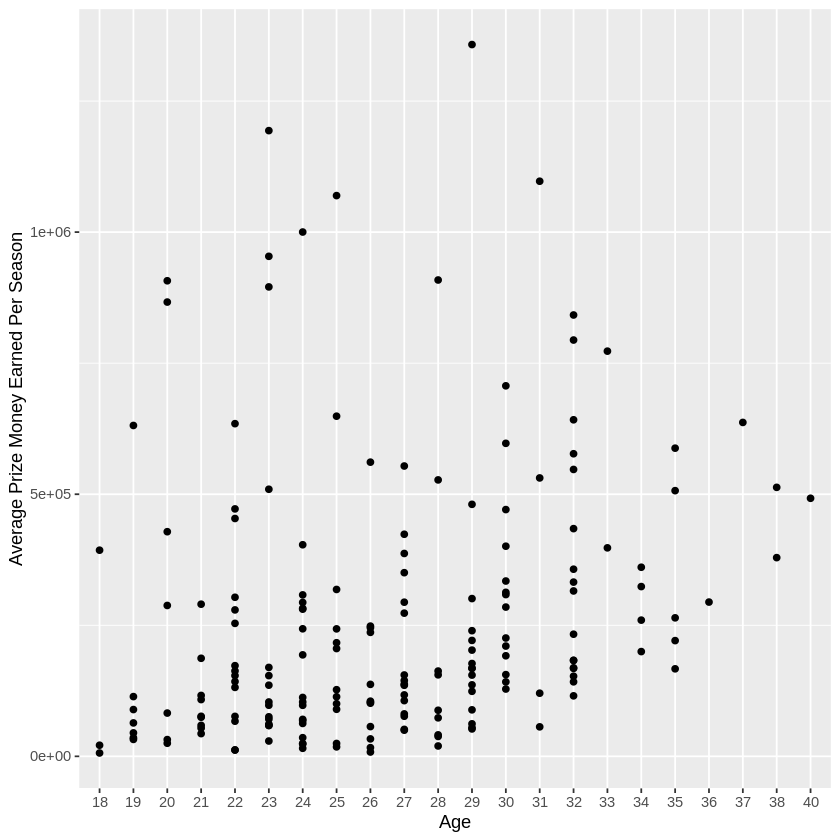

Warning message:
“Removed 20 rows containing missing values (geom_point).”


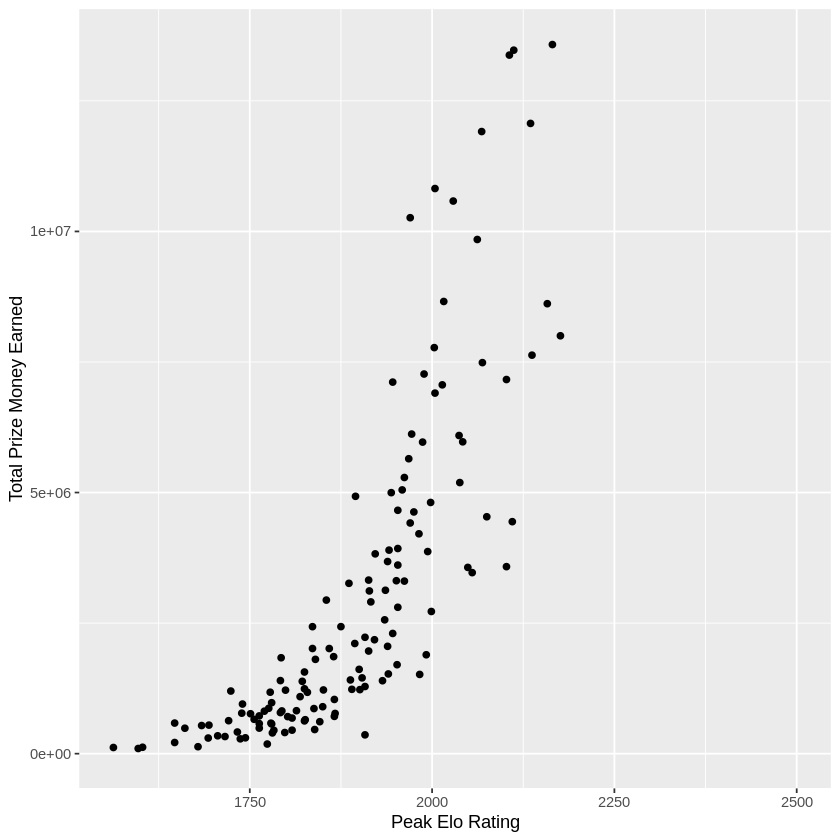

Warning message:
“Removed 89 rows containing missing values (geom_point).”


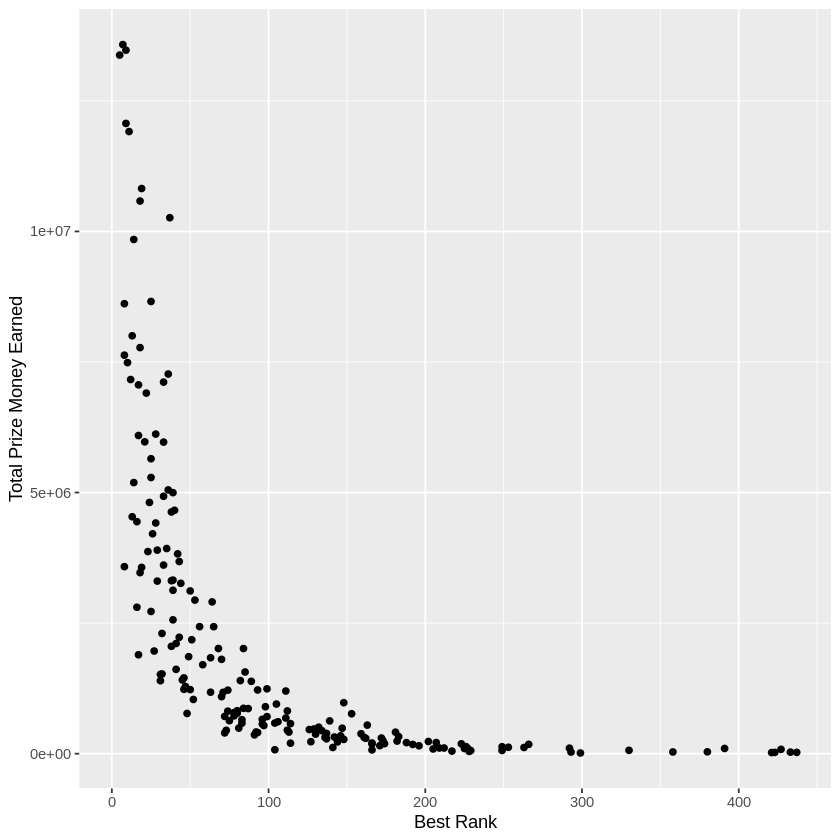

Warning message:
“Removed 20 rows containing missing values (geom_point).”


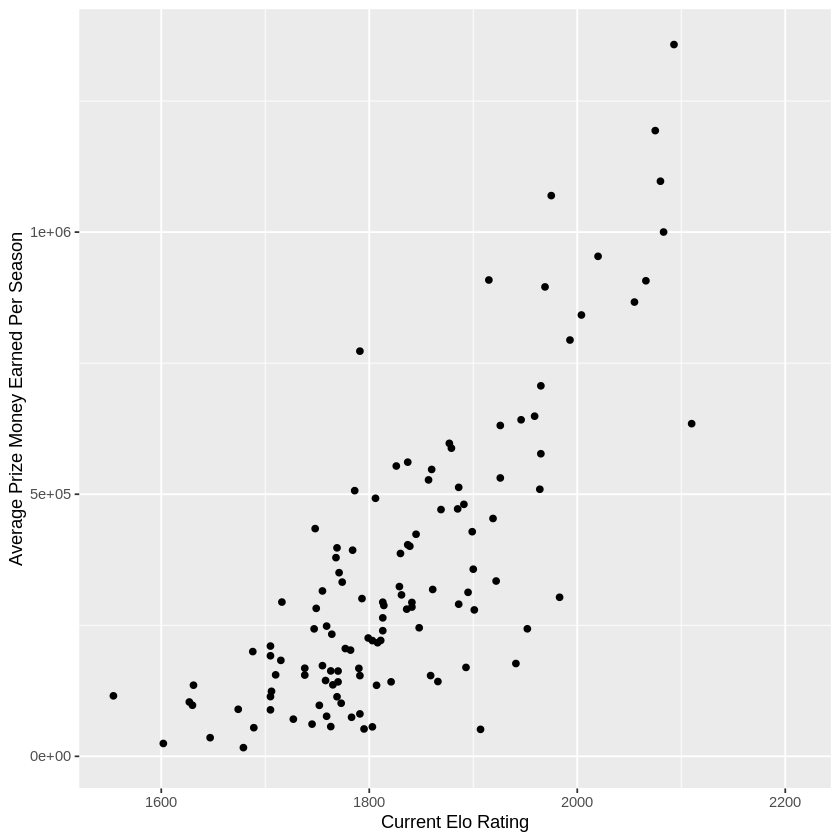

Warning message:
“Removed 74 rows containing missing values (geom_point).”


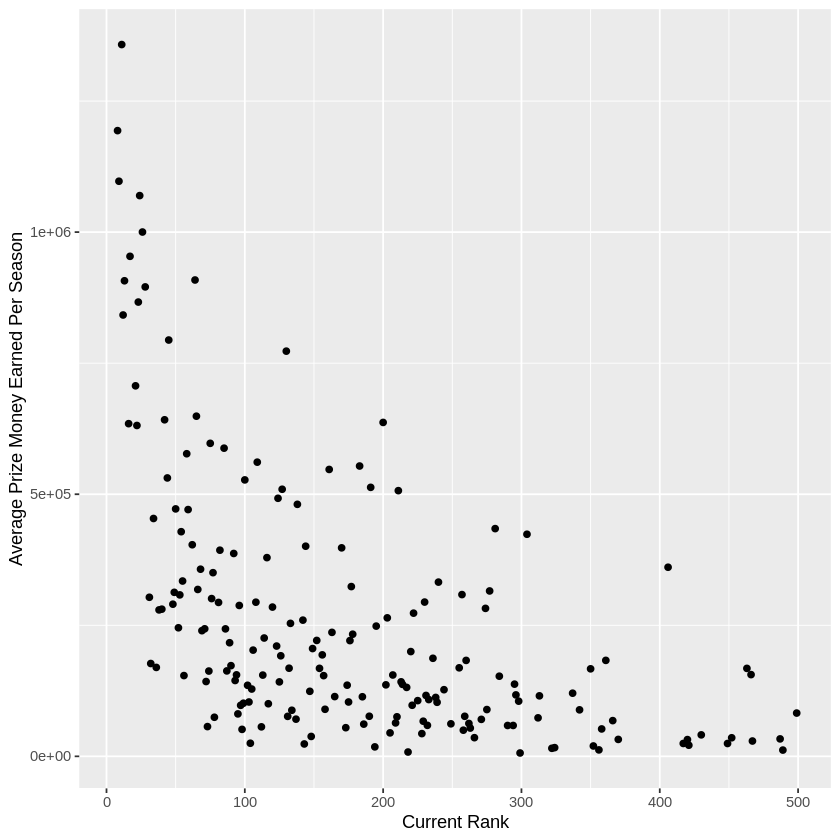

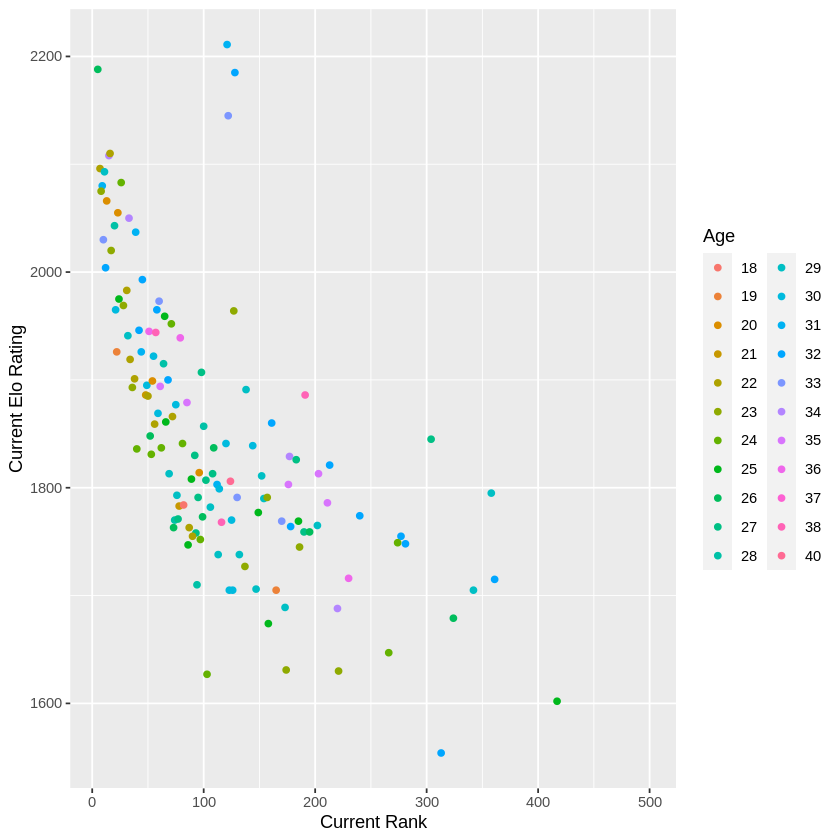

In [97]:
tennis_plot_seasons <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Prize.Money)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Total Prize Money Earned")
    ggtitle("Seasons vs Prize Money")
tennis_plot_money_per_season <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Average Prize Money Earned Per Season")
    ggtitle("Seasons vs Money per Seasons")
tennis_plot_age <- tennis_data_for_viz |>
    ggplot(aes(x = Age, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Age", y = "Average Prize Money Earned Per Season")
    ggtitle("Age vs Money Per Season")
tennis_plot_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Peak.Elo.Rating, y = Prize.Money)) +
    geom_point() +
    labs(x = "Peak Elo Rating", y  = "Total Prize Money Earned")
    ggtitle("Peak Elo Rating vs Prize Money")
tennis_plot_rank <- tennis_data_for_viz |>
    ggplot(aes(x = Best.Rank, y = Prize.Money)) +
    geom_point() +
    labs(x = "Best Rank", y = "Total Prize Money Earned")
    ggtitle("Best Rank vs Prize Money")
tennis_plot_elo_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Elo Rating", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Elo vs Money per Year")
tennis_plot_rank_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Rank", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Rank vs Money per Year")
tennis_plot_current_rank_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Current.Elo.Rating, color = Age)) +
    geom_point() +
    labs(x = "Current Rank", y = "Current Elo Rating")
    ggtitle("Current Rank vs Current Elo Rating")
tennis_plot_seasons
tennis_plot_money_per_season
tennis_plot_age
tennis_plot_elo
tennis_plot_rank
tennis_plot_elo_perYear
tennis_plot_rank_perYear
tennis_plot_current_rank_elo